# 05_cosine: Using Cosine Similarity to Determine Recommendations

**Description**: Tossing my dataset into a cosine similarity matrix to determine song recommendations.

## Table of Contents

1. [Cosine Similarity Overview](#1)
2. [Cosine Similarity Processing](#2)
3. [Creating Functions to Retrieve Similarity Scores](#3)
4. [Evaluating Songs in Matrix](#4)
5. [Retreiving Songs from Different Artists Only](#5)
6. [Evaluating `da` Recommendations](#6)
7. [Looking at How Similarity Ranks Between Each Observation](#7)
8. [Creating Function to Query Main Song List for Available Works](#8)

In [2]:
import pickle
import re

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

<a name="1"></a>
## 1. Cosine Similarity Overview

Cosine Similarity is the normalized dot product of two vectors, A & B, and can be written as such:

$$cos(\theta) = \frac{AB^T}{\|A\|\|B\|}$$

In the instance of this recommender the two vectors are the same, the overall song matrix derived in the Preprocessing notebook.

### 1a. Why Cosine Similarity?

The short of this is: Because it provided results that sounded the most similar to songs provided in testing.

#### Further Reasoning

I can understand the thought that a measurement like Euclidean distance makes more sense when trying to measure the similarity of songs using the feature sets that are incorporated here, wherein the most of the features are measurements centered around zero (in fact, you'll find my review on using Euclidean distance to find similar songs in the notebook, `v_euclidean`). However, in aggregate, the test results using cosine similarity sounded closer to the original titles provided than the results utilizing euclidean distance. The songs recommended through cosine similarity were also more diverse, in terms of the performing artist. Wherein, usine euclidean distance, there was a higher frequency of the same artist who performed the original song.

Cosine similarity also works well for dense data sets, which is exactly what we have for the genre based features passed through SVD. It's built to better incorporate the directionality of those genre components regardless of their magnitude.

##### Loading in matricies and df's from preprocessing

In [2]:
with open('../pickle/main_songs_scaled_svd.pkl', 'rb') as f:
    main_songs_scaled_svd = pickle.load(f)

In [11]:
main_songs_svdg = pd.read_csv('../data/main_songs_svdg.csv', index_col='song_id')

##### Retrieving the Primary Song Listing to help Lookup Song Titles

In [3]:
main_song_list = pd.read_csv('../data/main_wfeats.csv', index_col='song_id')

In [4]:
main_song_list.drop('Unnamed: 0', 1, inplace=True)

<a name="2"></a>
## 2. Cosine Similarity Processing

### 2a. Precomputing Cosine Similarity Matrix

##### SVD on Genres Only (50 total) + All Other Song Features

In [5]:
cos_sim_mat_g = cosine_similarity(main_songs_scaled_svd, main_songs_scaled_svd)
cos_sim_mat_g.shape

(22891, 22891)

Saving matrix as a .npy file

In [6]:
with open('../pickle/cos_sim_mat_g.npy', 'wb') as f:
    np.save(f, cos_sim_mat_g)   

In [5]:
with open('../pickle/cos_sim_mat_g.npy', 'rb') as f:
    cos_sim_mat_g = np.load(f)

In [6]:
len(cos_sim_mat_g)

22891

### 2b. Creating a Series of `dicts` for Lookup

In [7]:
song_id_name = dict(zip(main_song_list.index, main_song_list['song_title']))

In [8]:
song_id_artist = dict(zip(main_song_list.index, main_song_list['artist_name']))

In [9]:
song_id_name['6SluaPiV04KOaRTOIScoff']

'Show Me Love - Radio Version'

In [12]:
song_cosine_id = dict(zip(main_songs_svdg.index, range(main_songs_svdg.shape[0])))

In [13]:
song_cosine_idr = dict(zip(range(main_songs_svdg.shape[0]), main_songs_svdg.index))

In [14]:
song_cosine_id['3rbNV2GI8Vtd8byhUtXZID']

4222

In [15]:
main_song_list[main_song_list['artist_name'] == 'Kanye West']

,album_release_date,artist_id,artist_name,duration_ms,explicit,linked_album,song_title,danceability,energy,key,...,pv_dim_3,pv_dim_4,pv_dim_5,pv_dim_6,pv_dim_7,pv_dim_8,pv_dim_9,pv_dim_10,pv_dim_11,pv_dim_12
song_id,,,,,,,,,,,,,,,,,,,,,
12D0n7hKpPcjuUpcbAKjjr,2012-01-01,5K4W6rqBFWDnAN6FQUkS6x,Kanye West,283653.0,True,Kanye West Presents Good Music Cruel Summer,Don't Like.1,0.668,0.628,6,...,0.415775,0.288472,0.271070,0.286847,0.433189,0.340303,0.345500,0.381068,0.297665,0.229429
3rbNV2GI8Vtd8byhUtXZID,2012-01-01,5K4W6rqBFWDnAN6FQUkS6x,Kanye West,293533.0,True,Clique,Clique,0.467,0.564,9,...,0.226941,0.217918,0.216888,0.189842,0.260089,0.292166,0.409535,0.563234,0.425784,0.264578
2VYb3Fb5iK5Y8HGZ8oEEkp,2018-06-01,5K4W6rqBFWDnAN6FQUkS6x,Kanye West,215320.0,True,ye,Violent Crimes,0.665,0.417,1,...,0.227480,0.285250,0.300128,0.279523,0.396057,0.315203,0.298741,0.275292,0.264623,0.306519
2r4JRwcbIeuAzWjH4YXlLs,2018-06-01,5K4W6rqBFWDnAN6FQUkS6x,Kanye West,188773.0,True,ye,Yikes,0.676,0.777,1,...,0.347499,0.323991,0.288460,0.225888,0.196487,0.192628,0.311331,0.233684,0.173319,0.153491
1PS1QMdUqOal0ai3Gt7sDQ,2005-09-30,5K4W6rqBFWDnAN6FQUkS6x,Kanye West,207626.0,True,Late Registration,Gold Digger,0.638,0.699,1,...,0.365447,0.494928,0.466816,0.402411,0.582167,0.567909,0.598946,0.496505,0.378845,0.360558
2nBI3iWLhupR7LyAJ5GGkE,2016-06-10,5K4W6rqBFWDnAN6FQUkS6x,Kanye West,334253.0,True,Champions,Champions,0.695,0.777,6,...,0.351891,0.288690,0.300120,0.284733,0.338449,0.260932,0.256220,0.266580,0.241517,0.334226
2gZUPNdnz5Y45eiGxpHGSc,2010-01-01,5K4W6rqBFWDnAN6FQUkS6x,Kanye West,292093.0,True,My Beautiful Dark Twisted Fantasy,POWER,0.543,0.915,0,...,0.405668,0.316667,0.303952,0.368533,0.426505,0.543493,0.454580,0.397667,0.370878,0.384723
4sc2HuZ5ATXlX7WhnXuo0h,2012-01-01,5K4W6rqBFWDnAN6FQUkS6x,Kanye West,357320.0,True,Kanye West Presents Good Music Cruel Summer,New God Flow.1,0.425,0.947,3,...,0.375474,0.504604,0.325679,0.337340,0.447355,0.341610,0.402004,0.383456,0.507541,0.525236
6C7RJEIUDqKkJRZVWdkfkH,2007-01-01,5K4W6rqBFWDnAN6FQUkS6x,Kanye West,311866.0,True,Graduation,Stronger,0.625,0.726,10,...,0.404728,0.523766,0.438856,0.433573,0.364118,0.310894,0.284168,0.263753,0.321225,0.317311


<a name="3"></a>
## 3. Creating Functions to Retreive Similarity Scores

All of the below functions to retreive similarity scores are slight modifications on Douglas Strodtman's repo @ git.generalassemb.ly

### 3a. Searching for Most Similar Songs (Regardless of Artist)

In [16]:
def feat_sim(song_id, k=10, cos_sim_mat=cos_sim_mat_g):
    '''
    Returns array of indices for top k songs with greatest similarity to given song, along with 
    their similarity rating, based on precomputed cosine similarity of feature vectors.

    top_songs_feat, top_songs_feat_sim = get_sim.by_feats(ind_song_id, k, cos_sim_mat)

    '''
    top_songs_feat = np.argsort(cos_sim_mat[song_cosine_id[song_id]])[-2:-(k+2):-1]
    top_songs_feat_sim = np.sort(cos_sim_mat[song_cosine_id[song_id]])[-2:-(k+2):-1]

    return top_songs_feat, top_songs_feat_sim

### 3c. Retreiving Recommendations in a Dataframe

In [17]:
def get_recs(song_id, k=10, cos_sim_mat=cos_sim_mat_g):
    try:
        top_songs_feat, top_songs_feat_sim = feat_sim(song_id, k, cos_sim_mat)
        return pd.DataFrame([[song_id_name[song_cosine_idr[x]] for x in top_songs_feat],
                         [song_id_artist[song_cosine_idr[x]] for x in top_songs_feat],
                         [song_cosine_idr[x] for x in top_songs_feat],
                         list(top_songs_feat_sim)], 
                        index=['Song Name', 'Artist', 'Song ID', 'Similarity']).T
    except:
        print('No results available for that id. Please refer to the Song Finder for a list of valid ids.')

<a name="4"></a>
## 4. Evaluating Songs in Matrix

I decided to select a few titles that I had a good grasp of musically, to test the stength of the recommender.

### 4a. Grunge

There's far too much homogeneity within the first result. Homogeneity in terms of the artist. The design of this recommender is to allow listeners to discover music. While the dataset itself should be expanded to help with this, results should ideally reflect a fairly diverse group of acts. 

In [18]:
#Black Hole Sun - Soundgarden
get_recs('2EoOZnxNgtmZaD8uUmz2nD', k=10)

,Song Name,Artist,Song ID,Similarity
0,Pretty Noose,Soundgarden,6ZzeXWwDvMzrgCWt9RwBj1,0.85659
1,Rusty Cage,Soundgarden,6hqIXyo6GxydAnoI8XeIrV,0.855692
2,Burden In My Hand,Soundgarden,1iArQTuOzxvrtniGmkyy92,0.810819
3,Would?,Alice In Chains,5sFDReWLrZHLFZFjHsjUTS,0.805412
4,The Day I Tried To Live,Soundgarden,78YJJJH55MSyk7547100sW,0.79185
5,My Wave,Soundgarden,6ox3xc5CNTDQiAINfzP8Zw,0.778452
6,No Excuses,Alice In Chains,4PtZE0h5oyPhCtPjg3NeYQ,0.77532
7,Just Because,Jane's Addiction,3k6L0H08zSY5yRDgqI8fqx,0.774134
8,Rainier Fog,Alice In Chains,16muBPcWmkHSl1uM4tE8WL,0.771753
9,Plush - Remastered,Stone Temple Pilots,0CkspLl535ZxdwCRs8AdZ4,0.768853


#### 4b. Hip Hop

The first title is extremely similar, and I would say, the quality drops fairly sharp afterwards. Musically, there is a recurrent theme here, but the lyrical content is so different that it 

In [19]:
#Clique - Kanye West
get_recs('3rbNV2GI8Vtd8byhUtXZID', k=10)

,Song Name,Artist,Song ID,Similarity
0,Willy Wonka (feat. Offset),Macklemore,7uKSil5r7uHexnM9lukPTc,0.765891
1,3005,Childish Gambino,3Z2sglqDj1rDRMF5x0Sz2R,0.68663
2,Ladders,Mac Miller,39NDBdU5Xkm5pCFGa5kZtI,0.643684
3,No Role Modelz,J. Cole,62vpWI1CHwFy7tMIcSStl8,0.640834
4,Thrift Shop (feat. Wanz),Macklemore & Ryan Lewis,3AYcyxEACnmE6d96RPubID,0.634141
5,Freaks And Geeks,Childish Gambino,7xTY3rJMgj0nh6OOPHgsLw,0.623547
6,Ghost Town,Kanye West,6Bg7MznA9X0dIhlAsLyBYj,0.622416
7,By Design,Kid Cudi,5FxVTEpoBress37MmlMhbZ,0.618671
8,Don't Like.1,Kanye West,12D0n7hKpPcjuUpcbAKjjr,0.613521
9,God's Plan,Drake,6DCZcSspjsKoFjzjrWoCdn,0.607984


#### 4c. Personal Favorite

In [20]:
# Finesse (Remix) - Bruno Mars (feat. Cardi B)
get_recs('3Vo4wInECJQuz9BIBMOu8i', k=10)

,Song Name,Artist,Song ID,Similarity
0,That's What I Like - PARTYNEXTDOOR Remix,Bruno Mars,64TkpV7m7f09JY7K436pju,0.803541
1,The Party's Just Begun,The Cheetah Girls,5Au8ObNQvrwFVEgGqQQL6D,0.710488
2,24K Magic,Bruno Mars,6b8Be6ljOzmkOmFslEb23P,0.674512
3,One World - Soundtrack,The Cheetah Girls,7luYEwE4Y9Of5AKbrt0pJ4,0.674079
4,Good Day,DNCE,49X8pWDpmFpAITVUaudkcN,0.662769
5,Valerie - Glee Cast Version,Glee Cast,4hBW3h6FnQNh7NRmyxLLG7,0.654222
6,Malibu - Tiësto Remix,Miley Cyrus,7FKcbKrAi4uiXosKMNTjQI,0.645558
7,Lone Ranger,Rachel Platten,3eoyz3jZOHhko7hEwtEdnf,0.642873
8,24/Seven,Big Time Rush,6FkX1akf4mwRZSznL73kDR,0.642443
9,All In My Head (Flex),Fifth Harmony,7nD9nN3jord9wWcfW3Gkcm,0.639749


In [21]:
get_recs('6SluaPiV04KOaRTOIScoff', k=10)

,Song Name,Artist,Song ID,Similarity
0,Be Mine!,Robyn,3FtkFLmplS7GGPFMIQ0dSR,0.807176
1,Do You Know (What It Takes),Robyn,0idCpkJ2pspfAILbanmERu,0.73661
2,Fuck You,Lily Allen,1GCbc1vpkZA2zhjsSFhmHT,0.69611
3,Wannabe,Spice Girls,1Je1IMUlBXcx1Fz0WE7oPT,0.686487
4,2 Become 1,Spice Girls,36AWdhZIGLUTkWpJDhe7va,0.672988
5,Hang With Me,Robyn,6rW8q1p2GCjGMRAlnxBeo7,0.665758
6,Viva Forever,Spice Girls,6BPDPcnbDMDf58srVzbfX9,0.663578
7,Who Do You Think You Are,Spice Girls,1jI1aLmm5HTwiMtvsbwDJw,0.658066
8,Cruel Summer,Ace of Base,4AxVXHgv0clBuS4dl4S7Gw,0.636947
9,Barbie Girl,Aqua,2RSOzvKUnfDDrb2nQPfpQU,0.629162


In [22]:
# Helena - My Chemical Romance
get_recs('5dTHtzHFPyi8TlTtzoz1J9', k=10)

,Song Name,Artist,Song ID,Similarity
0,I'm Not Okay (I Promise),My Chemical Romance,7lRlq939cDG4SzWOF4VAnd,0.851958
1,Saying Sorry,Hawthorne Heights,0ZFUn5dFxuN3Um8y6ubX93,0.835861
2,Cry,The Used,4ETWkOTOxrcUf7YV9lc0TI,0.824815
3,Linoleum,NOFX,4uB28m7RAflobYpnLMb6A2,0.815379
4,Machine Gun Blues,Social Distortion,3d5Cnswx1dxmjUbn1Dp3JQ,0.800973
5,The Boys of Summer,The Ataris,5BmagRD7Thki6O1zZwbxBy,0.799609
6,Hell Above,Pierce The Veil,3EKh7JNsBrGoh2xqPotBKT,0.796601
7,Bulls In The Bronx,Pierce The Veil,23UoI3jlFiWdo5jadUYo69,0.793991
8,Radio #2,The Ataris,3RUy1m2LLhDUoCRdmwnUns,0.791341
9,Circles,Pierce The Veil,6zUy2nnchfZpzaDalE6sO2,0.790321


In [23]:
#Raining Blood - Slayer
get_recs('01Mpj13vURSO3cCLprPt5T')

,Song Name,Artist,Song ID,Similarity
0,Angel Of Death,Slayer,61dTqhd46yMkSWmC5LAh5F,0.920281
1,World Painted Blood,Slayer,4WFYHBYhFA6tmCRYKng2MB,0.918159
2,Repentless,Slayer,65POu6kUQdR33JxwN92afX,0.88191
3,South Of Heaven,Slayer,1f2nJKg780VxYIveVq6Xej,0.870896
4,Disciple,Slayer,0esBc6VgM4lFk3SOlL3Ys4,0.870654
5,Seasons In The Abyss,Slayer,59LtYLCNkesFkV3S4NhQyh,0.868236
6,Now You've Got Something to Die For,Lamb of God,6uw0ccDTu2taJB1KU6ggQk,0.852431
7,Hell Awaits,Slayer,3UKGPk85EhjqJSqePrSYeR,0.84911
8,Hourglass,Lamb of God,5ieTAoKNo9o5JjAouBRwTz,0.839968
9,Inner Self,Sepultura,3orEDNYiGeafDlFNSAZ2Lw,0.836053


In [24]:
#A Thousand Miles
get_recs('4w1lzcaoZ1IC2K5TwjalRP')

,Song Name,Artist,Song ID,Similarity
0,A Thousand Miles - Live Acoustic,Vanessa Carlton,1YuUPfLPOyvB1QYDKam0tc,0.829159
1,Who's To Say,Vanessa Carlton,4cv4oPc4EGAJCXtIBUtbxb,0.810664
2,Everywhere,Michelle Branch,1u0l8zWpQeMYStFkc2mLD7,0.723182
3,Pretty Baby,Vanessa Carlton,7LcA7GNjoHC2Z5wGbbVupx,0.709617
4,Pretty Baby,Vanessa Carlton,6HR041vuinw8ATBUWXgLOB,0.699391
5,You Get Me,Michelle Branch,1nZ6ZLqJ10L2gBmKcBR9hF,0.692242
6,Hands On Me,Vanessa Carlton,3G9pf9SNavqjDMHbeOIN8q,0.681245
7,Best You Ever,Michelle Branch,1BLIejgsEW10gWMRwqykN4,0.674095
8,Breathe,Michelle Branch,635mzxhITS1xY3AVSLKgyD,0.670639
9,Nolita Fairytale - Main,Vanessa Carlton,59d8G3noBayJU6fw34Ek1F,0.640346


<a name="5"></a>
## 5. Retreiving Songs from Different Artists Only

Ideally, the recommendations for a song should come from different artists than the one who performed it. Therefore, I also created a couple of functions to retrieve recommendations that aren't performed by the artist of the song given.

### 5a. Searching for Most Similar Songs (Must be Different Artist "da")

In [25]:
def feat_sim_da(song_id, k=10, song_db=main_song_list, cos_sim_mat=cos_sim_mat_g):
    '''
    Returns array of indices for top k songs with greatest similarity to a given song, but only
    from artists who didn't perform the given song, along with their similarity rating, 
    based on precomputed cosine similarity of feature vectors.

    top_songs_feat, top_songs_feat_sim = get_sim.by_feats(ind_song_id, k, cos_sim_mat)
    '''
    artist_id = song_db.loc[song_id, 'artist_id']
    artist_songs = song_db.index[song_db['artist_id'] == artist_id].drop(song_id)
    top_songs_feat = np.argsort(cos_sim_mat[song_cosine_id[song_id]])[-2:-(k+12):-1]
    top_songs_feat_sim = np.sort(cos_sim_mat[song_cosine_id[song_id]])[-2:-(k+12):-1]
    
    return top_songs_feat, top_songs_feat_sim, artist_songs

### 5b. Retreiving `da` Recommendations in a Dataframe

In [26]:
def get_recs_da(song_id, k=10, song_db=main_song_list, cos_sim_mat=cos_sim_mat_g):
    try:
        top_songs_feat, top_songs_feat_sim, artist_songs = feat_sim_da(song_id, k, main_song_list, cos_sim_mat)
        recs = [
            [song_id_name[song_cosine_idr[x]] for x in top_songs_feat],
            [song_id_artist[song_cosine_idr[x]] for x in top_songs_feat],
            [song_cosine_idr[x] for x in top_songs_feat],
            list(top_songs_feat_sim)
        ]

        recs = pd.DataFrame(recs, index=['Song Name', 'Artist', 'Song ID', 'Similarity']).T
        recs.set_index('Song ID', inplace=True)

        for song in artist_songs:
            if song in recs.index:
                recs.drop(song, inplace=True)

        recs.reset_index(inplace=True)
        return recs.head(k)
    except:
        print('No results available for that id. Please refer to the Song Finder for a list of valid ids.')

<a name="6"></a>
## 6. Evaluating `da` Recommendations

### 6a. Final Verdict on the Model

Due to the similarities being precomputed, the retrieval time for recommendations is satisfactory (see `With Arms Wide Open`).

A common theme between all these recommendations is the fairly sharp drop in quality beyond the first few songs. Again, the results still sound somewhat similar, though that's only due to the general "vibe" of the song, which I believe is captured within certain values of `Timbre`, and the `Genres` which had been flattened.

I think the variance in quality can pinned on a number of reasons:
- The size of the dataset is quite small. 22000 songs isn't quite enough to capture enough songs with significant similarity to one another
- Genres like Hip-Hop are hard to recommend on without lyrics as well. Songs in that genre are more reliant on that aspect of the music due to the lack of vocal melodies. 

All of that stated, I feel as though starting with a dataset RIAA award-winning was the correct route to take. For a dataset of the size, 10 songs per artist, it is a safe baseline of artists to choose from that most potential users of this recommender could recognize.

I plan on expanding observations in the dataset by first retreiving the remaining catalogs of each artist. Afterwards, I'll look to expand by perhaps capturing Billboard singles. Afterwards, I'll consider adding lyrics to the songs as well.

In [27]:
get_recs_da('4w1lzcaoZ1IC2K5TwjalRP')

,Song ID,Song Name,Artist,Similarity
0,1u0l8zWpQeMYStFkc2mLD7,Everywhere,Michelle Branch,0.723182
1,1nZ6ZLqJ10L2gBmKcBR9hF,You Get Me,Michelle Branch,0.692242
2,1BLIejgsEW10gWMRwqykN4,Best You Ever,Michelle Branch,0.674095
3,635mzxhITS1xY3AVSLKgyD,Breathe,Michelle Branch,0.670639
4,1le5KVGTF1xWf2aUj7ruLy,Fallin' For You,Colbie Caillat,0.639987
5,4rxll3CP6XklLuoki7A26P,Hopeless Romantic,Michelle Branch,0.634514
6,6NSJOIyKYcRZh28Kf0URTw,Goodbye To You,Michelle Branch,0.629146
7,42loEE51UDcecom9K8K4ei,I Do,Colbie Caillat,0.613212
8,5B7XIcS5T76NJZFOHX30Io,Are You Happy Now?,Michelle Branch,0.609449
9,07HeFSqsEGq4eWyerDrW1a,Back Home,Andy Grammer,0.599515


In [28]:
#Raining Blood - Slayer
get_recs_da('01Mpj13vURSO3cCLprPt5T')

,Song ID,Song Name,Artist,Similarity
0,6uw0ccDTu2taJB1KU6ggQk,Now You've Got Something to Die For,Lamb of God,0.852431
1,5ieTAoKNo9o5JjAouBRwTz,Hourglass,Lamb of God,0.839968
2,3orEDNYiGeafDlFNSAZ2Lw,Inner Self,Sepultura,0.836053
3,6vjvewW34Y3UiGQtJokGlY,Walk with Me In Hell,Lamb of God,0.813702
4,2SgbR6ttzoNlCRGQOKjrop,Cowboys From Hell,Pantera,0.811984
5,1kPbgEAGrsC7LhdYPdoWZ5,The Faded Line,Lamb of God,0.811407
6,0QRxtcxL31dRAeiUUuENPu,Territory,Sepultura,0.810881
7,0dqGfCMAGyDgpUAgLNOjWd,Fade To Black (Remastered),Metallica,0.810732
8,4LwdLLqeWKSVQ6vdw7Edoy,I Don't Wanna Be Me (Edit),Type O Negative,0.803118
9,4E5xVW505akJX0wcKj8Mpd,Tornado Of Souls - 2004 Digital Remaster,Megadeth,0.799274


In [29]:
#With Arms Wide Open - Creed
%time
get_recs_da('0s8OMEGJQJIUr9VFwNEH1v')

CPU times: user 10 µs, sys: 7 µs, total: 17 µs
Wall time: 62 µs


,Song ID,Song Name,Artist,Similarity
0,1VjYFbXSqx9Ly9GxQVUXV1,Bittersweet,Fuel,0.691316
1,3J19l4hOfwFFIF715BwVcG,Anthem for the Year 2000,Silverchair,0.690325
2,49dr2StmiAoPF2qvDCJtyc,I Can Still Feel You (feat. Thompson Square),Blues Traveler,0.663882
3,35EXxM1zE4eg2G6f3PSle4,Sunburn,Fuel,0.620032
4,6UdsizHr3xyknbT8cDQNZh,Spotlights,Candlebox,0.618006
5,5Bb88WRO4906ngHGMvkv4P,Cover Me,Candlebox,0.608484
6,2BLkpiR7oE09eY8DHUk6Bx,The Mountains Win Again,Blues Traveler,0.604864
7,32zMAD8gEAa0GHQohdzBh8,Swallowed,Bush,0.602442
8,4Jmh1oAENnA6JQqCQ8y9g7,Let Me Live Again,Our Lady Peace,0.597611
9,2B49LNSMgjaQJOa5fTml4M,Lost In You,Bush,0.591587


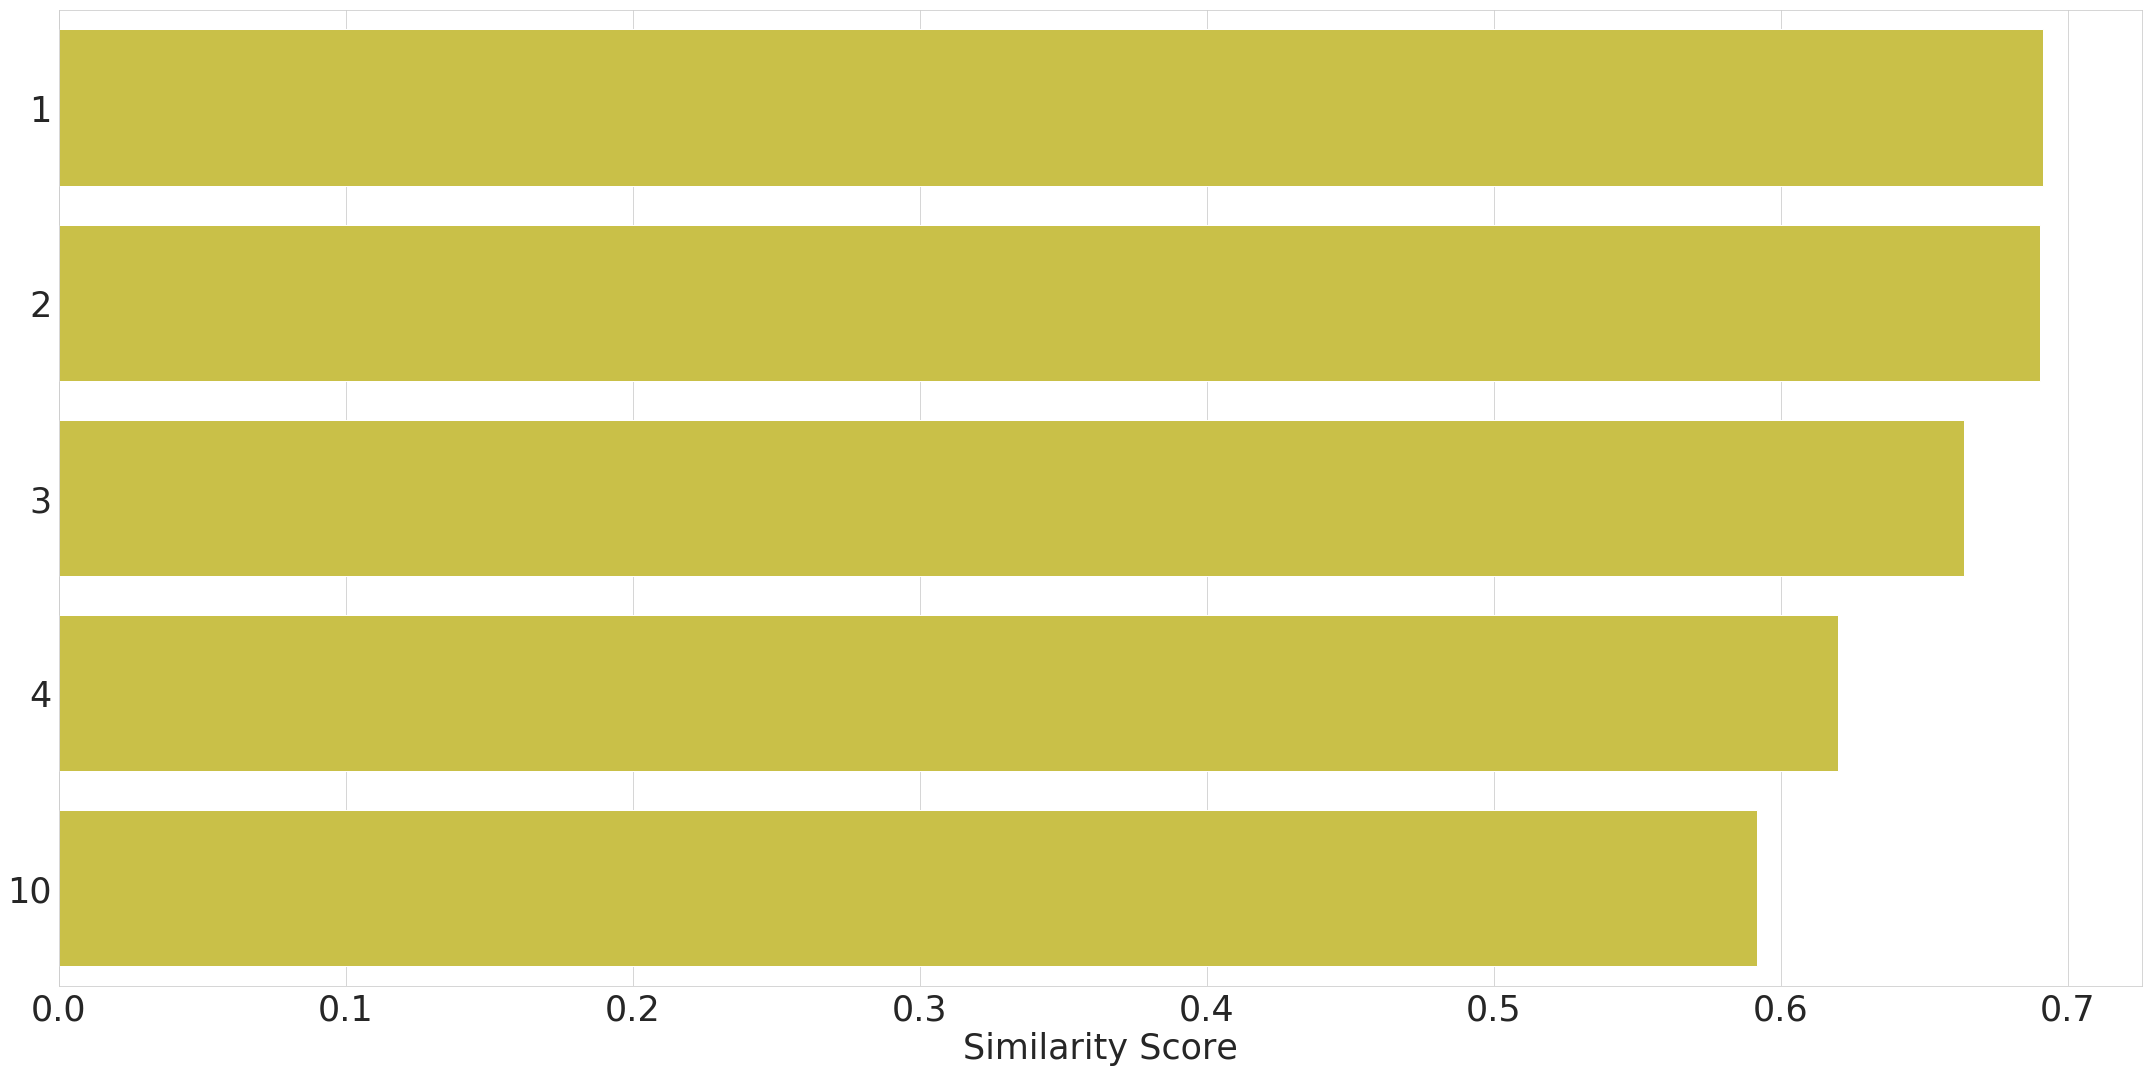

In [52]:
plt.figure(figsize=(30,15))
sns.set_style('whitegrid')
sns.barplot(y=get_recs_da('0s8OMEGJQJIUr9VFwNEH1v', k=10).drop([4,5,6,7,8]).index + 1
            ,x=get_recs_da('0s8OMEGJQJIUr9VFwNEH1v', k=10).drop([4,5,6,7,8])['Similarity'], color='#dfd232', orient='h')
plt.xticks(size=35)
plt.xlabel('Similarity Score', size=35)
plt.yticks(size=35)
plt.ylabel('', size=20)
plt.tight_layout()
plt.savefig('../images/awo_sim.png')

In [31]:
##### Helena - My Chemical Romance
get_recs_da('5dTHtzHFPyi8TlTtzoz1J9')

,Song ID,Song Name,Artist,Similarity
0,0ZFUn5dFxuN3Um8y6ubX93,Saying Sorry,Hawthorne Heights,0.835861
1,4ETWkOTOxrcUf7YV9lc0TI,Cry,The Used,0.824815
2,4uB28m7RAflobYpnLMb6A2,Linoleum,NOFX,0.815379
3,3d5Cnswx1dxmjUbn1Dp3JQ,Machine Gun Blues,Social Distortion,0.800973
4,5BmagRD7Thki6O1zZwbxBy,The Boys of Summer,The Ataris,0.799609
5,3EKh7JNsBrGoh2xqPotBKT,Hell Above,Pierce The Veil,0.796601
6,23UoI3jlFiWdo5jadUYo69,Bulls In The Bronx,Pierce The Veil,0.793991
7,3RUy1m2LLhDUoCRdmwnUns,Radio #2,The Ataris,0.791341
8,6zUy2nnchfZpzaDalE6sO2,Circles,Pierce The Veil,0.790321
9,54MXF9I8s3DuiQo3g0gZ5k,A Match Into Water,Pierce The Veil,0.785195


In [48]:
#Clique - Kanye West
get_recs_da('3rbNV2GI8Vtd8byhUtXZID', k=10)

,Song ID,Song Name,Artist,Similarity
0,7uKSil5r7uHexnM9lukPTc,Willy Wonka (feat. Offset),Macklemore,0.765891
1,3Z2sglqDj1rDRMF5x0Sz2R,3005,Childish Gambino,0.68663
2,39NDBdU5Xkm5pCFGa5kZtI,Ladders,Mac Miller,0.643684
3,62vpWI1CHwFy7tMIcSStl8,No Role Modelz,J. Cole,0.640834
4,3AYcyxEACnmE6d96RPubID,Thrift Shop (feat. Wanz),Macklemore & Ryan Lewis,0.634141
5,7xTY3rJMgj0nh6OOPHgsLw,Freaks And Geeks,Childish Gambino,0.623547
6,5FxVTEpoBress37MmlMhbZ,By Design,Kid Cudi,0.618671
7,6DCZcSspjsKoFjzjrWoCdn,God's Plan,Drake,0.607984
8,4faiJXyBflUVVOOE9fxbeg,Tie Me Down (feat. Ray J),New Boyz,0.59714
9,5ASZFbCod633wLragmPYTj,Renegade,JAY Z,0.591542


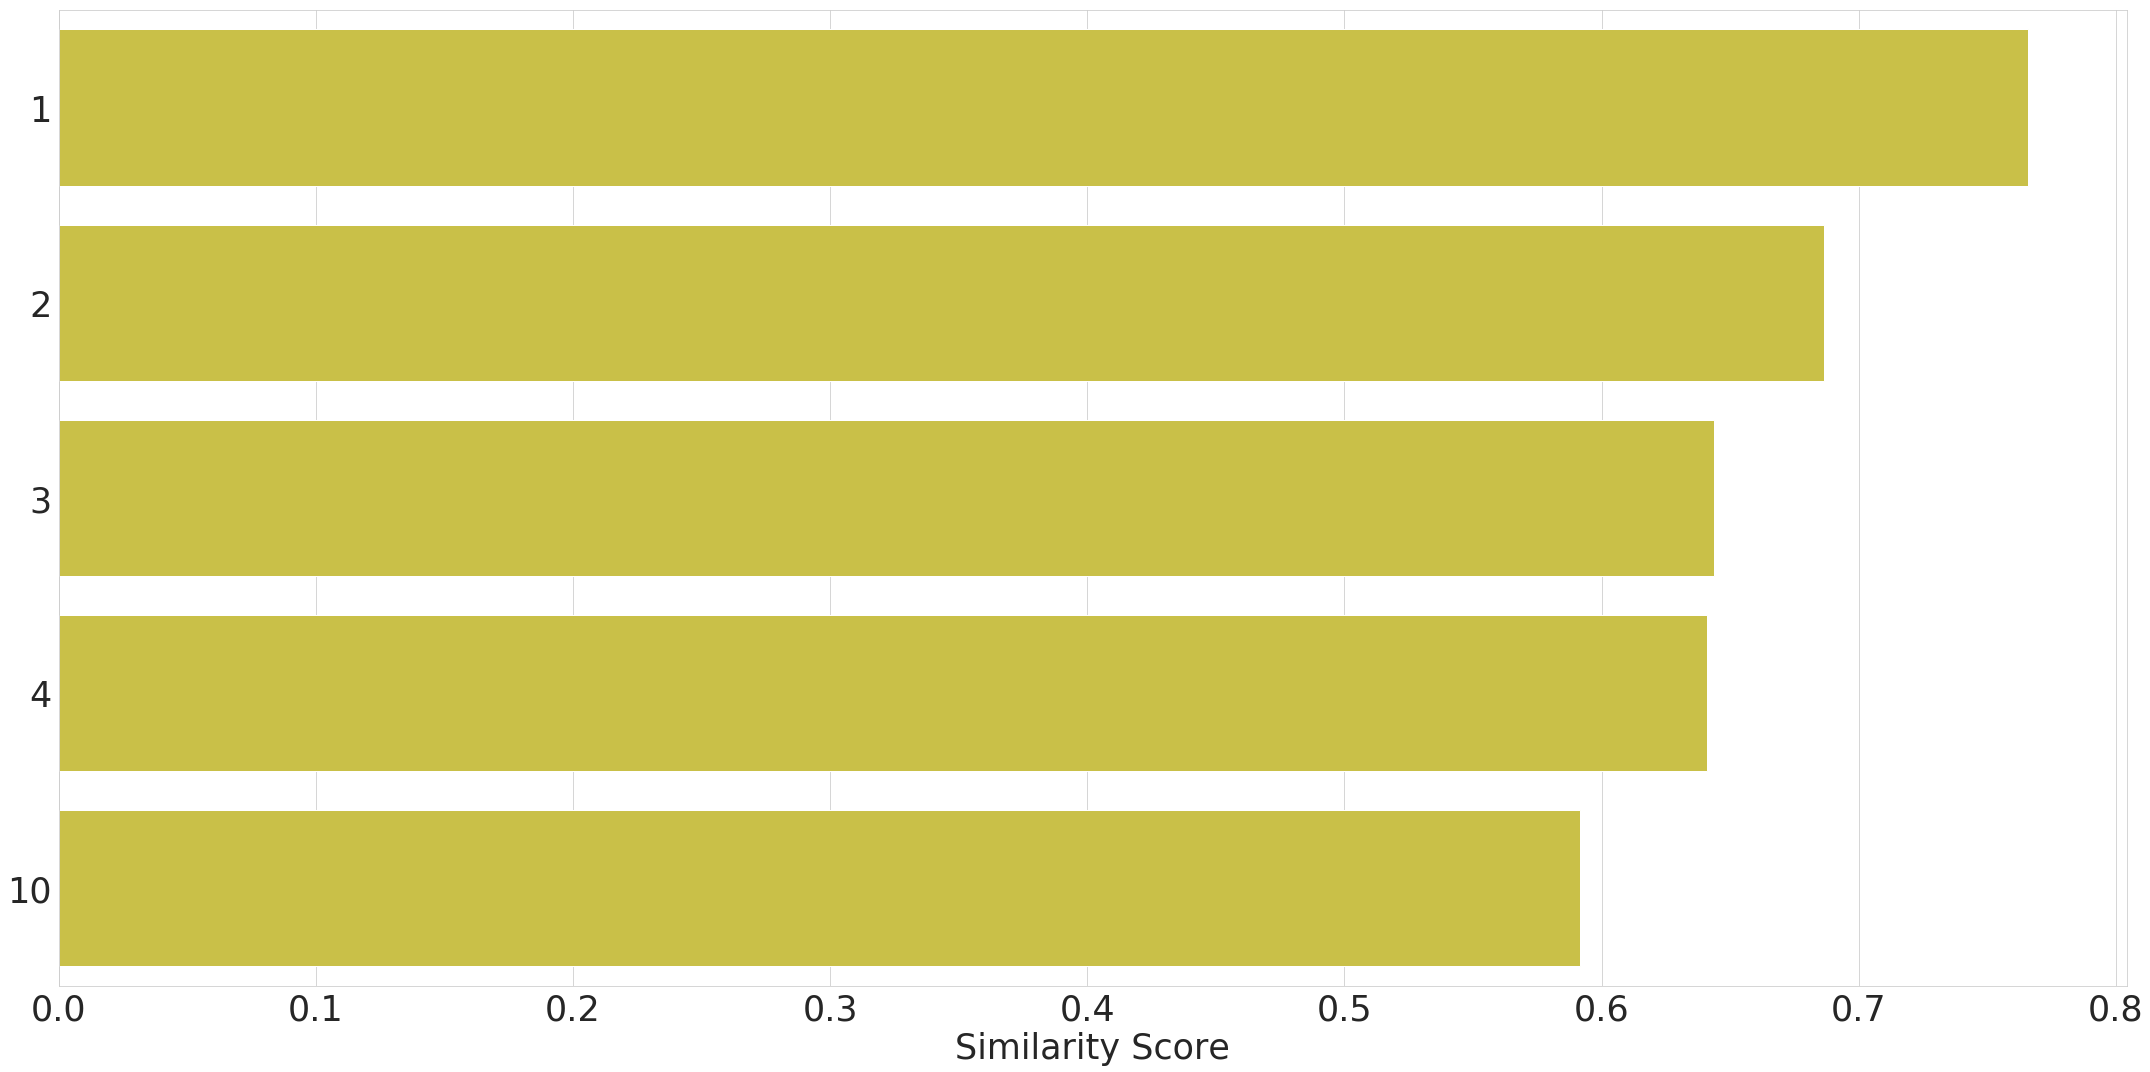

In [54]:
plt.figure(figsize=(30,15))
sns.set_style('whitegrid')
sns.barplot(y=get_recs_da('3rbNV2GI8Vtd8byhUtXZID', k=10).drop([4,5,6,7,8]).index + 1
            ,x=get_recs_da('3rbNV2GI8Vtd8byhUtXZID', k=10).drop([4,5,6,7,8])['Similarity'], color='#dfd232', orient='h')
plt.xticks(size=35)
plt.xlabel('Similarity Score', size=35)
plt.yticks(size=35)
plt.ylabel('', size=20)
plt.tight_layout()
plt.savefig('../images/clique_sim.png')

In [34]:
#Finesse (Remix) - Bruno Mars (feat. Cardi B)
get_recs_da('3Vo4wInECJQuz9BIBMOu8i', k=10)

,Song ID,Song Name,Artist,Similarity
0,5Au8ObNQvrwFVEgGqQQL6D,The Party's Just Begun,The Cheetah Girls,0.710488
1,7luYEwE4Y9Of5AKbrt0pJ4,One World - Soundtrack,The Cheetah Girls,0.674079
2,49X8pWDpmFpAITVUaudkcN,Good Day,DNCE,0.662769
3,4hBW3h6FnQNh7NRmyxLLG7,Valerie - Glee Cast Version,Glee Cast,0.654222
4,7FKcbKrAi4uiXosKMNTjQI,Malibu - Tiësto Remix,Miley Cyrus,0.645558
5,3eoyz3jZOHhko7hEwtEdnf,Lone Ranger,Rachel Platten,0.642873
6,6FkX1akf4mwRZSznL73kDR,24/Seven,Big Time Rush,0.642443
7,7nD9nN3jord9wWcfW3Gkcm,All In My Head (Flex),Fifth Harmony,0.639749
8,1uXbwHHfgsXcUKfSZw5ZJ0,Run the World (Girls),Beyoncé,0.637873
9,7bsYIRvIUztsOGVn2iW1ZT,TV In The Morning,DNCE,0.63248


In [35]:
#All Star - Smash Mouth
get_recs_da('3cfOd4CMv2snFaKAnMdnvK', k=10)

,Song ID,Song Name,Artist,Similarity
0,1iIXFwFEbvkCywvvFJPHCn,Zip-Lock,Lit,0.733812
1,6t7szVBSlD4Y2mhLMAbtaE,Down,Lit,0.713465
2,36UVZPoK8a1Oxh13cY8kOp,I Don't Wanna Be In Love (Dance Floor Anthem),Good Charlotte,0.65821
3,0SqgZ5KpfX24W8ZeGzOle2,Think Twice,Eve 6,0.652064
4,4GiVcDqNQI0fc0yYuRGH9m,Inside Out,Eve 6,0.645278
5,2QVg32eVhMvm2NfFfYnH1q,How Much Longer,Eve 6,0.644158
6,2RKmGDTq840oLpKC0WOaCr,Odds Are,Barenaked Ladies,0.642994
7,0eGagEzVbuRrDUJy3evjI3,Party On Apocalypse,New Found Glory,0.642903
8,4COleG16xBCkpofKHsJU2p,Ohio (Come Back To Texas),Bowling For Soup,0.638627
9,0peSmoFiYGaCkHibhLBGq2,Jet Lag - feat. Natasha Bedingfield,Simple Plan,0.63583


<a name="7"></a>
## 7. Looking at How Similarity Ranks Between Each Observation

I find it very interesting, that out of each similarity distribution below, the song that I've tested which has the flattest distribution is "Finesse", by Bruno Mars. That title was probably my favorite song this past summer, and it seems to have the least in common with the other recordings in this dataset. 

##### Creed - With Arms Wide Open

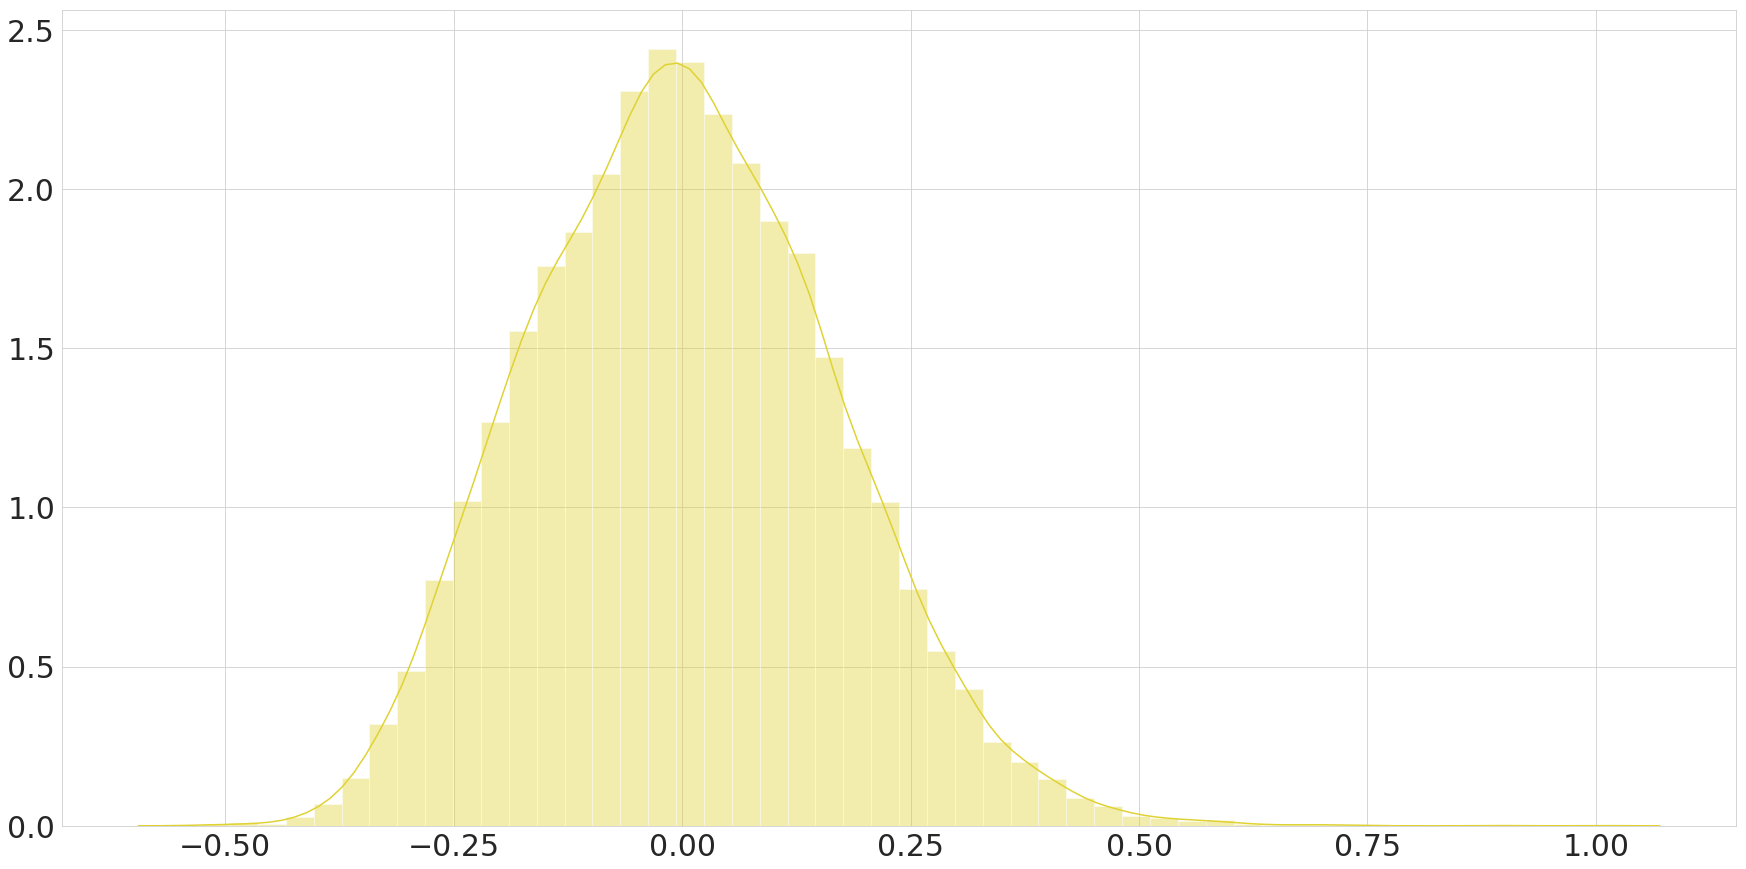

In [36]:
plt.figure(figsize=(30,15))
sns.distplot(cos_sim_mat_g[8812],
             color='#dfd232');
plt.xticks(size=30)
plt.yticks(size=30)
plt.savefig('../images/creed_dist.png', transparent=True)

#### Kanye West - Clique

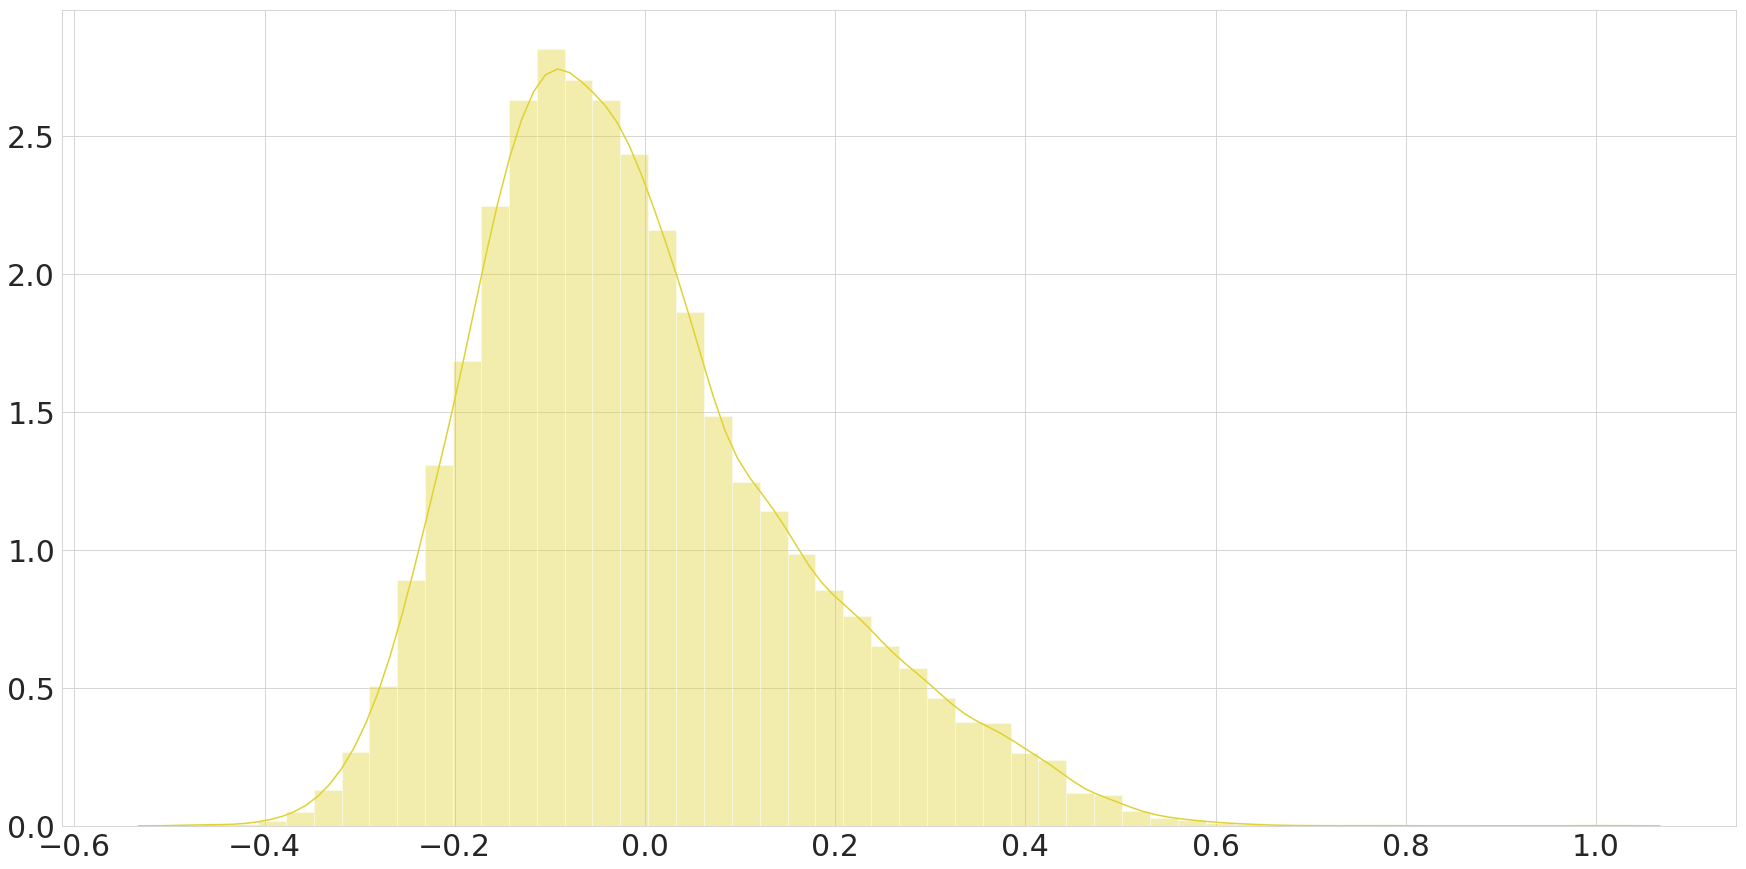

In [37]:
plt.figure(figsize=(30,15))
sns.distplot(cos_sim_mat_g[4222],
             color='#dfd232');
plt.xticks(size=30)
plt.yticks(size=30)
plt.savefig('../images/kanye_dist.png', transparent=True)

##### Bruno Mars - Finesse Remix (Feat. Cardi B)

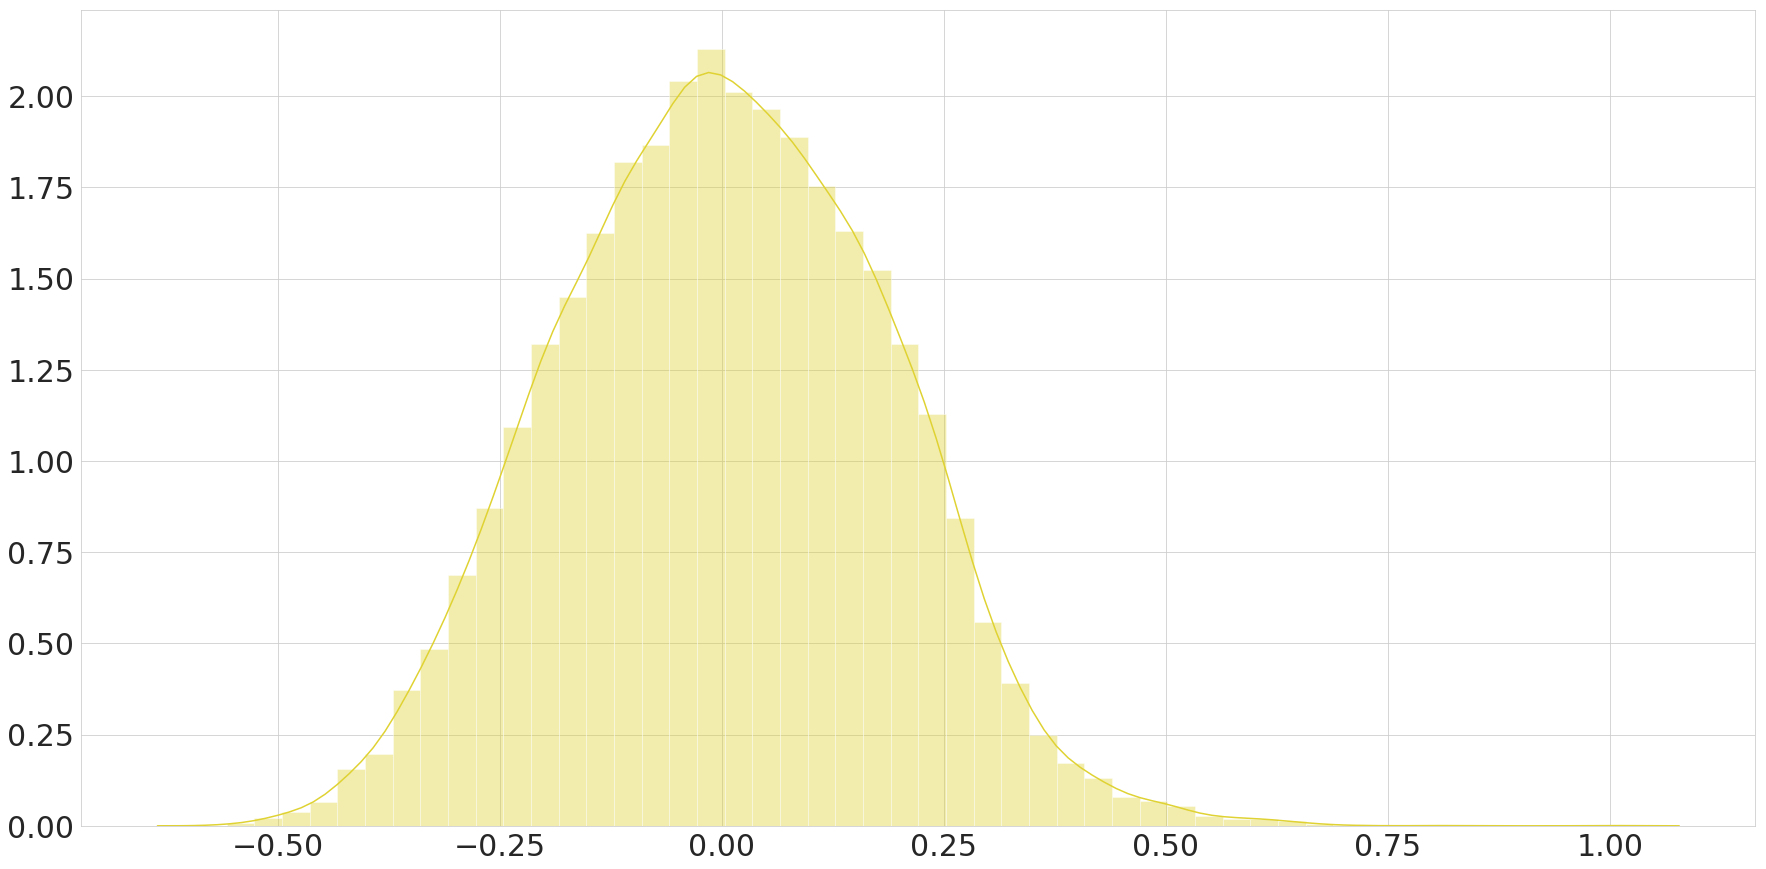

In [38]:
plt.figure(figsize=(30,15))
sns.distplot(cos_sim_mat_g[7949],
             color='#dfd232');
plt.xticks(size=30)
plt.yticks(size=30)
plt.savefig('../images/bruno_dist.png', transparent=True)

<a name="8"></a>
## 8. Creating Function to Query Main Song List for Available Works

In [39]:
def song_finder(artist_name, song_list=main_song_list):
    '''
    Retreives a list of valid song titles and corresponding id's given an artist name.
    Artist name should be given in lowercase.
    '''
    results = song_list[['artist_name', 'song_title']][song_list['artist_name'].apply(lambda x: x.lower()) == artist_name]
    if results.empty == True:
        return "Please try searching for another artist"
    else:
        return results.rename({'artist_name':'Artist Name',
                               'song_title':'Song Title'}, axis=1)

In [40]:
song_finder('eminem')

,Artist Name,Song Title
song_id,,
60SdxE8apGAxMiRrpbmLY0,Eminem,Lucky You (feat. Joyner Lucas)
2XTquzYQAdT1Hk78bOUwsv,Eminem,Greatest
2gsNpSn7VvvJuSrIDfRoYy,Eminem,Kamikaze
28FGV3ORH14MYORd7s5dlU,Eminem,Not Alike (feat. Royce Da 5'9)
0evt4UZbdhnHtcAnxkm6A1,Eminem,Normal
4UhUXGXEeq3mPJyzZkx9fY,Eminem,You Don't Know
2jt2WxXMCD4zjACthkJQVE,Eminem,The Ringer
66ezChUOWvgzRQAi3Ay1wt,Eminem,Go To Sleep
60Z57Wdrn0pEVpHI7d7GAX,Eminem,Stepping Stone
